In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
import numpy as np
import cv2
import pandas as pd

# Test Real Data

In [2]:
# Path to the data directory
path_name = r"C:\Users\Jitpanu\Desktop\superai\OCR\kaggle test set\combined_test"

# Get list of all the images
images = [cv2.imread(rf"{path_name}\{item}") for item in os.listdir(path_name)]
labels = [item.split(".")[0] for item in os.listdir(path_name)]

In [3]:
# fig, axs = plt.subplots(math.ceil(len(images)/5), 5, figsize=(30, 70))
img_dict = {}
for i in range(len(images)):
  img_dict[labels[i]] = images[i] 
#   axs[i // 5, i % 5].imshow(img_dict[labels[i]])
#   axs[i // 5, i % 5].set_title(labels[i])
#   axs[i // 5, i % 5].axis("off")

## Segmentation

In [4]:
def shadowFilter(img, printOption):
  rgb_planes = cv2.split(img)

  result_planes = []
  result_norm_planes = []
  for plane in rgb_planes:
      dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
      bg_img = cv2.medianBlur(dilated_img, 21)
      diff_img = 255 - cv2.absdiff(plane, bg_img)
      norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
      result_planes.append(diff_img)
      result_norm_planes.append(norm_img)

  result = cv2.merge(result_planes)
  result_norm = cv2.merge(result_norm_planes)
  if printOption:
    plt.imshow(result, cmap='gray')
    plt.title('result_planes')
    plt.show()

    plt.imshow(result_norm, cmap='gray')
    plt.title('result_norm_planes')
    plt.show()

  return result_norm

In [5]:
# Horizon Projection 
def horizontal_cropper(img_erosion, printOption):
  height, width = img_erosion.shape
  #upper_breakpoints, lower_breakpoints = horizontal_breakpoints(img_erosion, height, width)

  horizontal_projection = np.sum(img_erosion, axis=1)
  #print(horizontal_projection)

  blankImg = np.zeros((height, width, 3), np.uint8)
  for row in range(height):
    cv2.line(blankImg, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)
  
  if printOption:
    plt.imshow(blankImg)
    plt.title('Horizontal Projection')
    plt.show()

  # Find upper and lower cut off points in horizontal
  upper_breakpoints = []
  lower_breakpoints = []
  for row in range(height-1):
    if((int(horizontal_projection[row]*width/height) == 0) and (int(horizontal_projection[row+1]*width/height)) != 0):
      upper_breakpoints.append(row)
    if((int(horizontal_projection[row]*width/height) != 0) and (int(horizontal_projection[row+1]*width/height)) == 0 ):
      lower_breakpoints.append(row)

  #print(upper_breakpoints)
  #print(lower_breakpoints)

  images_cropped_1 = []

  for num in range(len(upper_breakpoints)):
    img = img_erosion[upper_breakpoints[num]:upper_breakpoints[num] +(lower_breakpoints[num] - upper_breakpoints[num]), 0:0+width]
    images_cropped_1.append(img)

  return images_cropped_1

In [6]:
# Histogram Projection
def histogram_projection(img_binary, printOption):
    img_binary[img_binary == 0] = 1
    img_binary[img_binary == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    img_erosion = cv2.erode(img_binary, kernel, iterations=0)
    if printOption:
      plt.imshow(img_erosion, cmap="gray")
      plt.title('Erosion Image')
      plt.show()

    img_erosion = cv2.copyMakeBorder(img_erosion, 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, value = 0)
    images_cropped_1 = horizontal_cropper(img_erosion, printOption)

    if len(images_cropped_1) > 1:
      summary = []
      position = 0

      for num in images_cropped_1:
        summary.append(sum(sum(num)))
      
      for i in range(len(summary)):
        if i == 0:
          maxValue = summary[i] 
          position = i
        if (maxValue < summary[i]) and (i > 0):
          maxValue = summary[i]
          position = i 

      temp = images_cropped_1[position]
      images_cropped_1.clear()
      images_cropped_1.append(temp)

    #Find the characters, Find first and last cut off character in vertical
    left_breakpoints = [[] for i in range(len(images_cropped_1))]
    right_breakpoints = [[] for i in range(len(images_cropped_1))]
    blankImgs = []
    for i in range(len(images_cropped_1)):
      vertical_projection = np.sum(images_cropped_1[i], axis=0)
      height_2, width_2 = images_cropped_1[i].shape
      blankImg2 = np.zeros((height_2, width_2, 3), np.uint8)
      for column in range(width_2-1):
        if ((int(vertical_projection[column]*width_2/height_2) == 0) and (int(vertical_projection[column+1]*width_2/height_2) != 0)):
          left_breakpoints[i].append(column)
        if ((int(vertical_projection[column]*width_2/height_2) != 0) and (int(vertical_projection[column+1]*width_2/height_2) == 0)):
          right_breakpoints[i].append(column)
        cv2.line(blankImg2, (column, 0), (column, int(vertical_projection[column]*width_2/height_2)), (255,255,255), 1)
      blankImgs.append(blankImg2)

    if printOption:
      figure = plt.figure(figsize=(20, 20))
      for i in range(len(blankImgs)):
        figure.add_subplot(2, 2, i+1)
        plt.imshow(blankImgs[i])
        plt.title('vertical Projection')
        plt.show()

    charImgs = []
    for i in range(len(left_breakpoints)):
      for num, num2 in zip(left_breakpoints[i], right_breakpoints[i]):
        img = images_cropped_1[i]
        img = img[0:0+height_2, num: num + num2 - num]
        horizontal_projection = np.sum(np.sum(img, axis=1))
        #print(np.sum(horizontal_projection))
        if horizontal_projection > 10:
          charImgs.append(img)
        #print(charImgs)
        if len(charImgs) >= 5 :
          break

    if printOption:
      figure = plt.figure(figsize=(15, 20))
      for i in range(len(charImgs)):
        figure.add_subplot(6,6,i+1)
        plt.imshow(charImgs[i], cmap='gray')

    return charImgs

In [7]:
# Find character in image
def character_segment(image, printOption):
    if printOption:
      plt.imshow(image, cmap='gray')
      plt.title('Input Image')
      plt.show()

    img = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    img = cv2.resize(img, (252, 84))
    img = shadowFilter(img, printOption)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img_gray = cv2.medianBlur(img_gray, 3)

    kernel = np.ones((3, 3), np.uint8)
    #img_dilation = cv2.dilate(img_gray, kernel, iterations=1)
    #img_erosion = cv2.erode(img_dilation, kernel, iterations=1)

    (thresh, img_binary) = cv2.threshold(img_gray, 10, 255, 
                                      cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    if printOption:
      plt.imshow(img_gray, cmap='gray')
      plt.title('Grayscale Image')
      plt.show()

      plt.imshow(img_binary, cmap='gray')
      plt.title('Binary Image')
      plt.show()

    char_list = histogram_projection(img_binary, printOption)

    return char_list

In [8]:
# Processing Char to 28x28 size for Prediction
def character_processing(char_list):
  for i in range(len(char_list)):
    height, width = char_list[i].shape
    horizontal_projection = np.sum(char_list[i], axis=1)

    upper_breakpoints = 0 
    lower_breakpoints = 0

    for num in range(len(horizontal_projection)):
      if upper_breakpoints == 0:
        if horizontal_projection[num] != 0 :
          upper_breakpoints = num+1
      else:
        break

    for num in reversed(range(len(horizontal_projection))):
      if  lower_breakpoints == 0:
        if horizontal_projection[num] != 0 :
          lower_breakpoints = num+1
      else:
        break

    upper_breakpoints = upper_breakpoints
    lower_breakpoints = lower_breakpoints

    #print(upper_breakpoints)
    #print(lower_breakpoints)

    newChar = char_list[i]
    char_list[i] = newChar[upper_breakpoints:upper_breakpoints+(lower_breakpoints-upper_breakpoints),0:0+width] 

    newHeight, newWidth = char_list[i].shape
    distance = newHeight - newWidth
    distance = int(math.sqrt(distance**2))
    #print(distance)

    padLeft = int(distance/2)
    padRight = int(distance - padLeft)
    #print(padLeft)
    #print(padRight)

    #plt.imshow(char_list[i], cmap='gray')
    #plt.title('Padding')
    #plt.show()

    kernel = np.ones((3, 3), np.uint8)
    padChar = char_list[i]
    padChar = cv2.copyMakeBorder(padChar, 4, 4, padLeft+4, padRight+4, cv2.BORDER_CONSTANT, None, value = 0)
    padChar = cv2.dilate(padChar, kernel, iterations=1)
    char_list[i] = cv2.resize(padChar, (28, 28))
    #char_list[i] = cv2.dilate(char_list[i], kernel, iterations=1)
    #char_list[i] = cv2.erode(char_list[i], kernel, iterations=1)

  return char_list

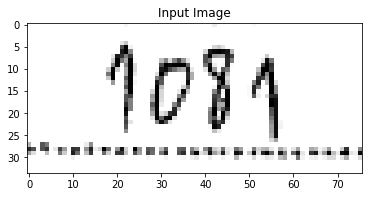

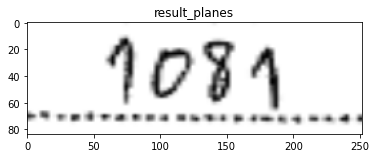

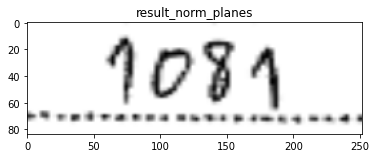

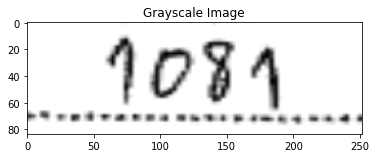

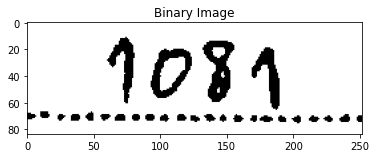

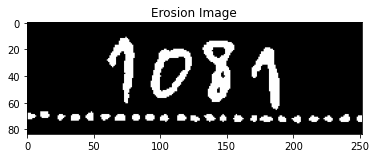

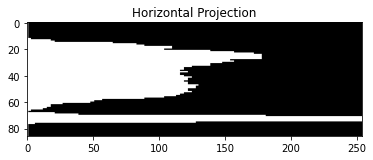

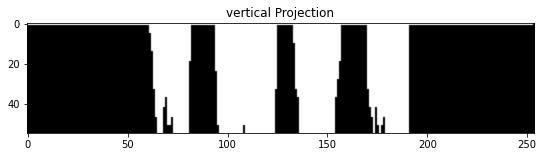

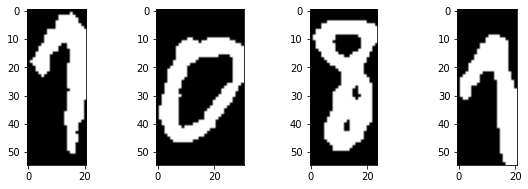

In [9]:
#char = character_segment(img_dict['31215'], printOption = True)
char = character_segment(img_dict['7f57ce882645db17d8f7fb8d6f787006'], printOption = True)
char_list = character_processing(char)

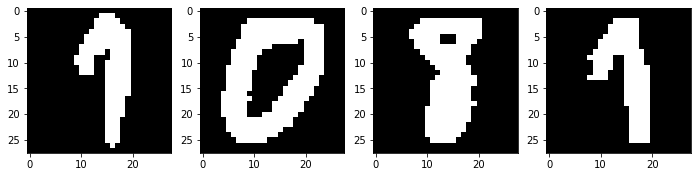

In [10]:
figure = plt.figure(figsize=(15, 20))
for i in range(len(char)):
  figure.add_subplot(1,5,i+1)
  plt.imshow(char[i], cmap='gray')
  #plt.axis('off')

# Prediction

In [11]:
model_name ='99-my_model_Bi_AugZ,R_Gen_E70'
recon_model=tf.keras.models.load_model(f'saved_model/{model_name}')

In [12]:
recon_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [13]:
# Prepare Character Dataset
char_dict = {}
char_label = {}

for name in labels:
  try:
    char = character_segment(img_dict[name], printOption = False)
  except:
    print('Unknow: '+name)
    continue
  char_dict[name] = character_processing(char)
  char_label[name] = list(name)

print('Detected: '+format(len(char_dict)))

Detected: 2170


In [14]:
# fig, axs = plt.subplots(len(char_dict), 5, figsize=(20, 500))

# for n, name in enumerate(char_dict):
#   for i in range(len(char_dict[name])):
#     axs[n, i % 5].imshow(char_dict[name][i], cmap='gray')
#     axs[n, i % 5].set_title('ID:'+name)
#     axs[n, i % 5].axis("off")

In [ ]:
# Character Predicted
result_dict = {}

for n, name in enumerate(char_dict):
  result = []
  for i in range(len(char_dict[name])):
    predicted = np.argmax(recon_model.predict(np.expand_dims(char_dict[name][i],axis=0)))    
    result.append(predicted)    
  result_dict[name] = result

In [ ]:
# Visual Predicted
# fig, axs = plt.subplots(len(char_dict), 5, figsize=(20, 500))

# for n, name in enumerate(char_dict):  
#   for i in range(len(char_dict[name])):    
#     axs[n, i % 5].imshow(char_dict[name][i], cmap='gray')
#     axs[n, i % 5].set_title('Label index: '+format(labels.index(name))+' Predicted:'+format(result_dict[name][i]))    
#     axs[n, i % 5].axis("off")
  

In [ ]:
# Handwriting number result
# fig, axs = plt.subplots(math.ceil(len(images)/5), 5, figsize=(20, 150))

result_csv = {}

for i in range(len(images)):
  result_csv[labels[i]] = ''.join(map(str, result_dict.get(labels[i])))
#   axs[i // 5, i % 5].imshow(img_dict[labels[i]])
#   axs[i // 5, i % 5].set_title('Num Label: '+format(i)+' Predicted:'+''.join(map(str, result_dict.get(labels[i]))))
#   axs[i // 5, i % 5].axis("off")

In [ ]:
# #check some weird point
# index_l=805
# char = character_segment(img_dict[labels[index_l]], printOption = True)
# char_list = character_processing(char)

## Submission

In [ ]:
fig, axs = plt.subplots(100, 5, figsize=(20, 150))

for i in range(500):  #show 500 from example
  axs[i // 5, i % 5].imshow(img_dict[labels[i]])
  axs[i // 5, i % 5].set_title('Num Label: '+format(i)+' Predicted:'+''.join(map(str, result_dict.get(labels[i]))))
  axs[i // 5, i % 5].axis("off")

In [ ]:
result_csv[labels[88]]

In [ ]:
result_csv

In [ ]:
new_df = pd.DataFrame.from_dict(result_csv, orient="index").reset_index()
new_df.columns = ['Id', 'Predicted']

In [ ]:
new_df.info()

In [ ]:
# test_path = r'C:\Users\Jitpanu\Desktop\superai\OCR\kaggle test set\sample_submission.csv'

#First
# #Import CSV
# df = pd.read_csv(test_path)

# #Updated 
# df['Predicted'] = df[["Id","Predicted"]].apply(lambda x : result_csv[x["Id"]] if x["Id"] in result_csv.keys() else x["Predicted"],axis=1)  

# #check not null
# df["Predicted"].notnull().sum()

#Export CSV
new_df.to_csv(r"C:\Users\Jitpanu\Desktop\superai\OCR\kaggle test set\test_submit_5.csv",index=False)  

In [ ]:
new_df["Predicted"].notnull().sum()

In [ ]:
#recheck format
df_c = pd.read_csv(r"C:\Users\Jitpanu\Desktop\superai\OCR\kaggle test set\test_submit_4.csv",
                   converters={'Predicted': lambda x: str(x)})
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
df_c